<a href="https://colab.research.google.com/github/larin92/ML_zoomcamp/blob/main/06-trees/06-homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from numpy import ndarray

%matplotlib inline

### Task

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

The goal of this homework is to create a regression model for predicting housing prices (`median_house_value`).

In [2]:
# !command style for colab use
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
# df_raw = pd.read_csv('housing.csv')

df_raw = pd.read_csv('../01-intro/housing.csv')
TARGET_COLUMN = 'median_house_value'

In [3]:
print(df_raw.head())
print("\nshape: ", df_raw.shape)

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  

shape:  (20640, 10)


### EDA

- Look at the `median_house_value` variable.

In [4]:
df_raw.median_house_value.describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

<Axes: xlabel='median_house_value', ylabel='Count'>

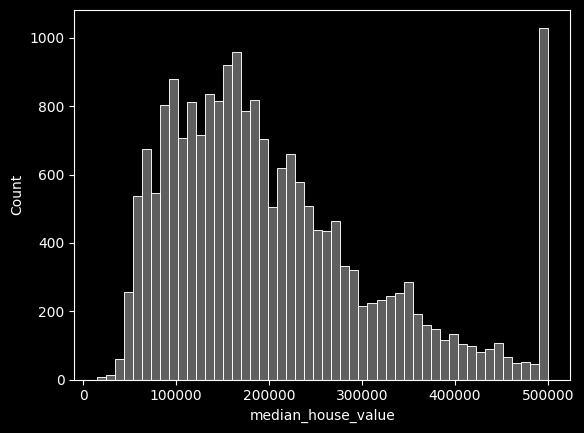

In [5]:
plt.style.use("dark_background")
sns.histplot(df_raw[TARGET_COLUMN], bins=50, color='grey')

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df_raw.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Filtering the dataset

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

Keep only the records where `ocean_proximity` is either `<1H OCEAN` or `INLAND`.

In [8]:
df_filtered = df_raw[df_raw['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
print(df_filtered.ocean_proximity.value_counts(), '\n')
df_filtered.reset_index(drop=True, inplace=True)
print(df_filtered.info())

ocean_proximity
<1H OCEAN    9136
INLAND       6551
Name: count, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15687 entries, 0 to 15686
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
 9   ocean_proximity     15687 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.2+ MB
None


### Preparation:

- Fill missing values with zeros.
- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)) matrices.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

def train_val_test_split(df: pd.DataFrame, frac=[0.6, 0.2, 0.2], seed=1):
    train_size = frac[0]
    test_size = frac[2]
    relative_val_size = frac[1] / (train_size + test_size)
    
    df = df.copy()
    target = df.pop(TARGET_COLUMN)
    
    X_train, X_test, y_train, y_test \
        = train_test_split(df, target, test_size=test_size, random_state=seed)
    
    X_train, X_val, y_train, y_val \
        = train_test_split(X_train, y_train, test_size=relative_val_size, random_state=seed)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

df_filtered.fillna(0, inplace=True)
df_filtered[TARGET_COLUMN] = np.log1p(df_filtered[TARGET_COLUMN])

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_filtered)

dv = DictVectorizer()
X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))
X_test = dv.transform(X_test.to_dict(orient='records'))

C:\Users\larki\AppData\Local\Temp\ipykernel_15016\2153287032.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.fillna(0, inplace=True)
C:\Users\larki\AppData\Local\Temp\ipykernel_15016\2153287032.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[TARGET_COLUMN] = np.log1p(df_filtered[TARGET_COLUMN])


In [10]:
def rmse(y_true, y_pred):
    se = (y_true - y_pred) ** 2
    mse = se.mean()
    
    return np.sqrt(mse)

## Question 1

Train a decision tree regressor with `max_depth=1` to predict the `median_house_value` variable. 

Which feature is used for splitting the data?

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

In [22]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

results = rf.predict(X_val)
rmse(y_val, results)

0.24527740463893763

## Question 3

Experiment with the `n_estimators` parameter:

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

After which value of `n_estimators` does RMSE stop improving (consider 3 decimal places)?

In [26]:
scores = {}

for n in range(10, 210, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    results = rf.predict(X_val)
    scores[n] = rmse(y_val, results)

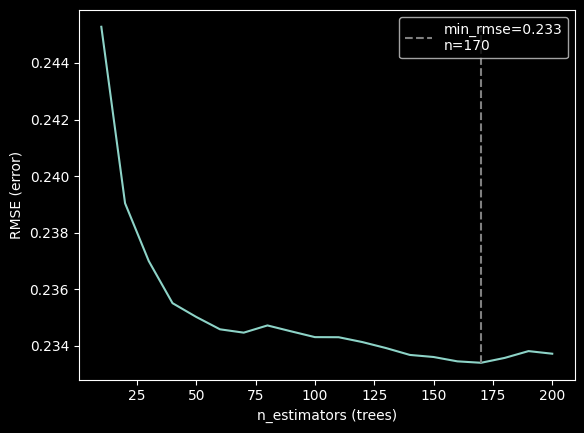

In [37]:
plt.plot(scores.keys(), scores.values())
plt.xlabel("n_estimators (trees)")
plt.ylabel("RMSE (error)")

min_rmse = min(scores.values())
max_rmse = max(scores.values())
n = list(scores)[list(scores.values()).index(min_rmse)]
plt.vlines(
    n,
    ymin=min_rmse, ymax=max_rmse, linestyles='dashed', colors='grey',
    label=f'min_rmse={min_rmse.round(3)}\nn={n}'
)
plt.legend()

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`

What's the best `max_depth`, using the mean RMSE?

In [55]:
scores_depth = {}
scores_n = {}
mean_rmse_by_depth = {}

for max_depth in [10, 15, 20, 25]:
    for n in range(10, 210, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        results = rf.predict(X_val)
        scores_n[n] = rmse(y_val, results)
    scores_depth[max_depth] = scores_n
    mean_rmse_by_depth[max_depth] = sum(scores_n.values())/len(scores_n)

In [59]:
df_depth = pd.DataFrame({'max_depth': mean_rmse_by_depth.keys(), 'mean_rmse': mean_rmse_by_depth.values()})
df_depth.sort_values(by='mean_rmse')

,max_depth,mean_rmse
3,25,0.234794
2,20,0.235168
1,15,0.235970
0,10,0.245526


In [ ]:
# TODO: plot

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [53]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

df_imp = pd.DataFrame({'feature': dv.get_feature_names_out(), 'importance': rf.feature_importances_})
df_imp.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.102007
3,longitude,0.086244
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030317
7,population,0.027136
9,total_rooms,0.021417
8,total_bedrooms,0.015852
0,households,0.015136


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

In [58]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [59]:
import xgboost as xgb

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_scores = {}

c:\Users\larki\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [60]:
%%capture output

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)
y_pred = model.predict(dval)
xgb_scores['eta=0.3'] = rmse(y_val, y_pred)

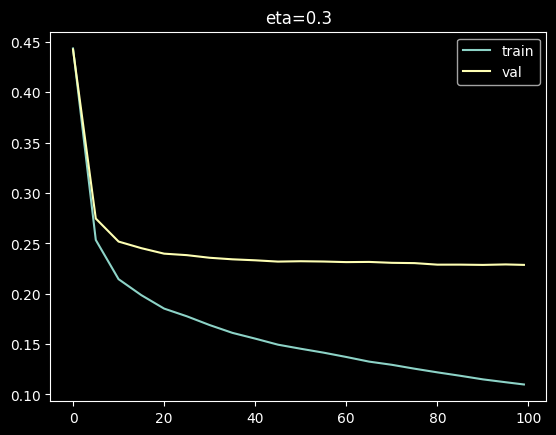

In [61]:
df_score_eta03 = parse_xgb_output(output)
plt.plot(df_score_eta03.num_iter, df_score_eta03.train_auc, label='train')
plt.plot(df_score_eta03.num_iter, df_score_eta03.val_auc, label='val')
plt.title("eta=0.3")
plt.legend()

In [62]:
%%capture output

xgb_params['eta'] = 0.1
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)
y_pred = model.predict(dval)
xgb_scores['eta=0.1'] = rmse(y_val, y_pred)

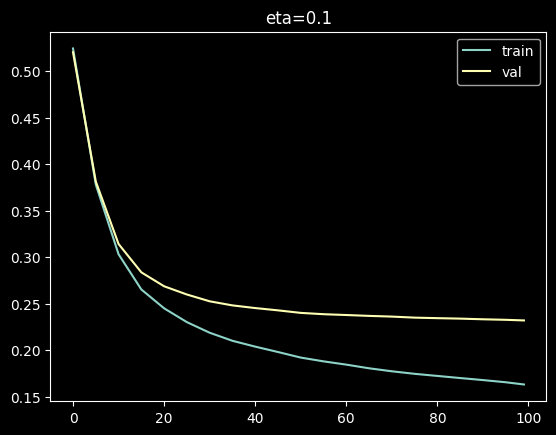

In [63]:
df_score_eta01 = parse_xgb_output(output)
plt.plot(df_score_eta01.num_iter, df_score_eta01.train_auc, label='train')
plt.plot(df_score_eta01.num_iter, df_score_eta01.val_auc, label='val')
plt.title("eta=0.1")
plt.legend()

In [64]:
xgb_scores

{'eta=0.3': 0.228623199980106, 'eta=0.1': 0.23208927121609343}